In [1]:
!pip install prophet


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import csv
import pandas as pd
from prophet import Prophet
import os
import glob

In [3]:
cwd = os.path.abspath('')
#list all the files from the directory
file_list = os.listdir(cwd)
csv_files = glob.glob('*.{}'.format('csv'))
df = pd.DataFrame()
for file in csv_files:
            df_temp = pd.read_csv(file)
            df = df.append(df_temp, ignore_index=True)
print(df)

       Unnamed: 0            id                             created_at  \
0               5  1.496830e+18  2022-02-24 15:10:39 GTB Standard Time   
1               7  1.496840e+18  2022-02-24 15:18:52 GTB Standard Time   
2               9  1.496840e+18  2022-02-24 15:20:30 GTB Standard Time   
3              10  1.496840e+18  2022-02-24 15:20:35 GTB Standard Time   
4              11  1.496840e+18  2022-02-24 15:22:31 GTB Standard Time   
...           ...           ...                                    ...   
32198       16722  1.523800e+18  2022-05-10 02:13:02 GTB Daylight Time   
32199       16723  1.523810e+18  2022-05-10 02:20:42 GTB Daylight Time   
32200       16724  1.523810e+18  2022-05-10 02:20:42 GTB Daylight Time   
32201       16725  1.523810e+18  2022-05-10 02:49:55 GTB Daylight Time   
32202       16726  1.523810e+18  2022-05-10 02:49:55 GTB Daylight Time   

            date      time         username                  name  \
0      2/24/2022  15:10:39      levi_godma

In [4]:
columns = ['date','tweet','sentiment','time']
df = df.reindex(columns=columns)
print(df)

            date                                              tweet  \
0      2/24/2022                          @ASBMilitary Good luck ??   
1      2/24/2022  Ukrainian border guards crossed into Russia in...   
2      2/24/2022  Ukrainian air defense systems were suppressed ...   
3      2/24/2022  @theragex Guys please tripple check videos bef...   
4      2/24/2022  Peskov: special operation in Ukraine dictated ...   
...          ...                                                ...   
32198  5/10/2022  Video of a Ukrainian soldier firing an NLAW at...   
32199  5/10/2022  The proposal exceeds the $33 billion that U.S....   
32200  5/10/2022  ?? Reuters: US Congress plans almost $40 billi...   
32201  5/10/2022  According to the Ukrainian government and the ...   
32202  5/10/2022  ?? Politico: European Commission discusses joi...   

       sentiment      time  
0       2.312161  15:10:39  
1       0.661490  15:18:52  
2       1.035298  15:20:30  
3       2.045095  15:20:35  
4 

In [5]:
df_pro=pd.DataFrame()
df_pro['ds'] = df['date']
df_pro['y'] = df['sentiment'].values
m=Prophet()
model=m.fit(df_pro)
days_in_future=100 #how many days in future to predict
future=m.make_future_dataframe(periods=days_in_future, freq = 'D',include_history = 'false') 
forecast=m.predict(future)
print(forecast)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqaq1v374/w1b57wgs.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpqaq1v374/p5s8iyno.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.8/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=23808', 'data', 'file=/tmp/tmpqaq1v374/w1b57wgs.json', 'init=/tmp/tmpqaq1v374/p5s8iyno.json', 'output', 'file=/tmp/tmpqaq1v374/prophet_modelcoibc81q/prophet_model-20230205173502.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
17:35:02 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
17:35:06 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


            ds     trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0   2022-02-24 -0.213665   -2.926014    2.604054    -0.213665    -0.213665   
1   2022-02-25 -0.211192   -2.845891    2.419368    -0.211192    -0.211192   
2   2022-02-26 -0.208718   -2.937935    2.738123    -0.208718    -0.208718   
3   2022-02-27 -0.206245   -3.045830    2.435459    -0.206245    -0.206245   
4   2022-02-28 -0.203772   -3.112456    2.830730    -0.203772    -0.203772   
..         ...       ...         ...         ...          ...          ...   
171 2022-08-14  0.353500   -2.673110    3.086599    -0.233130     0.909139   
172 2022-08-15  0.358999   -2.411115    3.303611    -0.237033     0.920523   
173 2022-08-16  0.364498   -2.482963    2.984567    -0.239396     0.928983   
174 2022-08-17  0.369997   -2.478856    3.433480    -0.240879     0.939406   
175 2022-08-18  0.375496   -2.467201    3.265792    -0.244467     0.955399   

     additive_terms  additive_terms_lower  additive_terms_upper

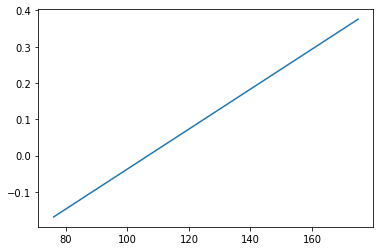

In [6]:
predicted=forecast[len(forecast)-days_in_future:len(forecast)]
predicted=predicted['trend']
predicted.plot()

In [24]:
#!pip install mxnet gluonts ujson
from gluonts.dataset.common import ListDataset
from gluonts.dataset.util import to_pandas
from gluonts.mx import DeepAREstimator
from gluonts.mx.distribution import ZeroInflatedNegativeBinomialOutput, StudentTOutput #likelihood
from gluonts.mx.trainer.learning_rate_scheduler import LearningRateReduction
from gluonts.mx.trainer import Trainer
from gluonts.mx.trainer.model_averaging import ModelAveraging, SelectNBestSoftmax, SelectNBestMean
import statistics
from gluonts.evaluation import Evaluator
from gluonts.evaluation.backtest import make_evaluation_predictions
import numpy as np

df_glutons = df.copy()
df_glutons["timestamp"] = df_glutons['date'].astype(str) +"-"+ df_glutons['time']
df_glutons.time = pd.to_datetime(df_glutons['timestamp'])
df_glutons.set_index("timestamp",drop=True, inplace=True)
print(df_glutons)

training_data = ListDataset(
    [{"start": df_glutons.index[0], "target": df_glutons.sentiment[:"5/5/2022-0:56:16"], }],
    freq = "D"
)
test_data = ListDataset(
    [{"start": df_glutons.index[27], "target": df_glutons.sentiment["5/5/2022-0:56:16":"5/10/2022-2:49:55"], }],
    freq = "D"
)

callbacks = [
    LearningRateReduction(objective="min",
                          patience=10,
                          base_lr=1e-3,
                          decay_factor=0.5,
                          ),
    ModelAveraging(avg_strategy=SelectNBestMean(num_models=2))
]

estimator = DeepAREstimator(
    freq="D",
    prediction_length=24,
    context_length=24,
    num_layers = 2,
    num_cells = 40,
    distr_output=StudentTOutput(),
    dropout_rate=0.01,
    trainer=Trainer(#ctx = mx.context.gpu(),
                    epochs=50,
                    callbacks=callbacks))

predictor = estimator.train(training_data)
predictions = predictor.predict(test_data,100)
predictions = list(predictions)[0]
#print(predictions.samples)
final_results=[]
for arr in predictions.samples:
  final_results.append(np.median(arr))

print(final_results)

                         date  \
timestamp                       
2/24/2022-15:10:39  2/24/2022   
2/24/2022-15:18:52  2/24/2022   
2/24/2022-15:20:30  2/24/2022   
2/24/2022-15:20:35  2/24/2022   
2/24/2022-15:22:31  2/24/2022   
...                       ...   
5/10/2022-2:13:02   5/10/2022   
5/10/2022-2:20:42   5/10/2022   
5/10/2022-2:20:42   5/10/2022   
5/10/2022-2:49:55   5/10/2022   
5/10/2022-2:49:55   5/10/2022   

                                                                tweet  \
timestamp                                                               
2/24/2022-15:10:39                          @ASBMilitary Good luck ??   
2/24/2022-15:18:52  Ukrainian border guards crossed into Russia in...   
2/24/2022-15:20:30  Ukrainian air defense systems were suppressed ...   
2/24/2022-15:20:35  @theragex Guys please tripple check videos bef...   
2/24/2022-15:22:31  Peskov: special operation in Ukraine dictated ...   
...                                                        

100%|██████████| 50/50 [00:24<00:00,  2.04it/s, epoch=50/50, avg_epoch_loss=1.95]


[0.21153331, -0.2830732, 0.6578963, -0.28896266, -0.4354282, 0.74087906, -0.1987346, -0.738528, 0.6295948, -0.38131183, 0.48598248, -0.110600665, -0.09531288, -0.55236536, -0.40441898, -0.3186298, -0.030892536, -0.30931532, -0.38260928, 0.042103704, 0.15773368, -0.24429446, 0.25856507, 0.19654801, 0.01977694, -0.057642963, 0.017580912, 0.4268767, 0.40987188, 0.088660255, -0.8206264, -0.3890345, 0.28749552, -0.13591668, 0.58381546, 0.057286967, 0.39899147, 0.3328336, -0.1363305, -0.017115671, 0.19128035, -0.81457376, -1.0301979, -0.39109457, 0.03333963, 0.7959101, -0.37406152, 0.082562566, 0.07772553, 0.1480039, -0.27627295, -0.7545854, 0.027724743, -0.26305673, -0.2913223, 0.51442146, 0.14208317, -0.0018810714, 0.5196043, 0.02790114, 0.32646492, 0.49618447, 0.89242125, -0.33079854, 0.87420845, 0.55389905, 0.11596662, -0.055430476, -0.5306025, 0.3226393, -0.12985744, -0.11693558, -0.31142697, 0.46302122, -0.35438937, 0.38578445, -0.4066052, 0.25913504, 0.30572575, -0.7163822, -0.1209078

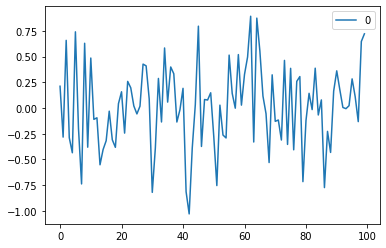

In [25]:
from array import array
f_res=np.array(final_results)
dff = pd.DataFrame(final_results)
dff.plot()